In [8]:
import random
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from PIL import Image
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from tqdm.auto import tqdm


In [9]:
%load_ext autoreload
%autoreload 2

from src.model.CNN_regression import (
    DBHDepthDataset,
    DBHRegressor,
    evaluate,
    get_eval_transforms,
    train_one_epoch,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from huggingface_hub import hf_hub_download
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CONFIG = {
    "model_name": "microhum/resnet50_224_depth_dbh_DA3_LARGE_20260210_0423_38_best",
    "model_file": "resnet50_224_depth_dbh_DA3_LARGE_20260210_0423_38_best.pt",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}


# Load the model
def load_model():
    """Load the trained model from Hugging Face Hub"""
    try:
        model_path = hf_hub_download(
            repo_id=MODEL_CONFIG["model_name"], filename=MODEL_CONFIG["model_file"]
        )

        # Create model architecture using DBHRegressor from CNN_regression
        model = DBHRegressor("resnet50")

        # Load trained weights
        state_dict = torch.load(model_path, map_location=MODEL_CONFIG["device"])

        # handle DataParallel checkpoints
        

        model.load_state_dict(state_dict)
        model.eval()

        logger.info(f"Model loaded successfully on {MODEL_CONFIG['device']}")
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise


# Initialize model
model = load_model()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/microhum/resnet50_224_depth_dbh_DA3_LARGE_20260210_0423_38_best/resolve/main/resnet50_224_depth_dbh_DA3_LARGE_20260210_0423_38_best.pt "HTTP/1.1 302 Found"
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:httpx:HTTP Request: HEAD https://huggingface.co/timm/resnet50.a1_in1k/resolve/main/model.safetensors "HTTP/1.1 302 Found"
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:__main__:Model loaded successfully on cuda


: 

In [ ]:
def load_model(backbone, checkpoint_path, device):
    model = DBHRegressor(backbone)
    state_dict = torch.load(checkpoint_path, map_location=device)

    # handle DataParallel checkpoints
    if any(k.startswith("module.") for k in state_dict.keys()):
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

: 

In [ ]:
@torch.no_grad()
def visualize_random_test_samples(
    checkpoint_path: str,
    backbone: str,
    test_csv: str,
    base_path: str,
    k: int = 4,
    image_size: int = 192,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    base_path = Path(base_path)
    df = pd.read_csv(test_csv)

    samples = df.sample(k)

    model = load_model(backbone, checkpoint_path, device)
    model.eval()

    # IMPORTANT: same transforms as eval
    depth_transform = get_eval_transforms(
        image_size=image_size,
        in_channels=1,
    )

    fig, axes = plt.subplots(k, 2, figsize=(10, 2 * k))

    if k == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (_, row) in enumerate(samples.iterrows()):
        rgb_path = base_path / "test" / row["image_path"]
        depth_path = base_path / row["depth_anything_maps_path"]
        gt_dbh = row["DBH"]

        # --- RGB (for visualization only)
        rgb = Image.open(rgb_path).convert("RGB")

        # --- Depth (for model input)
        depth = np.load(depth_path).astype(np.float32)
        depth = np.clip(depth, 0, 255).astype(np.uint8)
        depth_pil = Image.fromarray(depth, mode="L")

        depth_tensor = depth_transform(depth_pil).unsqueeze(0).to(device)

        # predict
        pred_dbh = model(depth_tensor).item()
        pred_dbh = np.expm1(pred_dbh)
        
        # --- plot RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("RGB Image")
        axes[i, 0].axis("off")

        # --- plot depth
        axes[i, 1].imshow(depth, cmap="gray")
        axes[i, 1].set_title(
            f"Depth Map\nGT: {gt_dbh:.2f} cm | Pred: {pred_dbh:.2f} cm"
        )
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


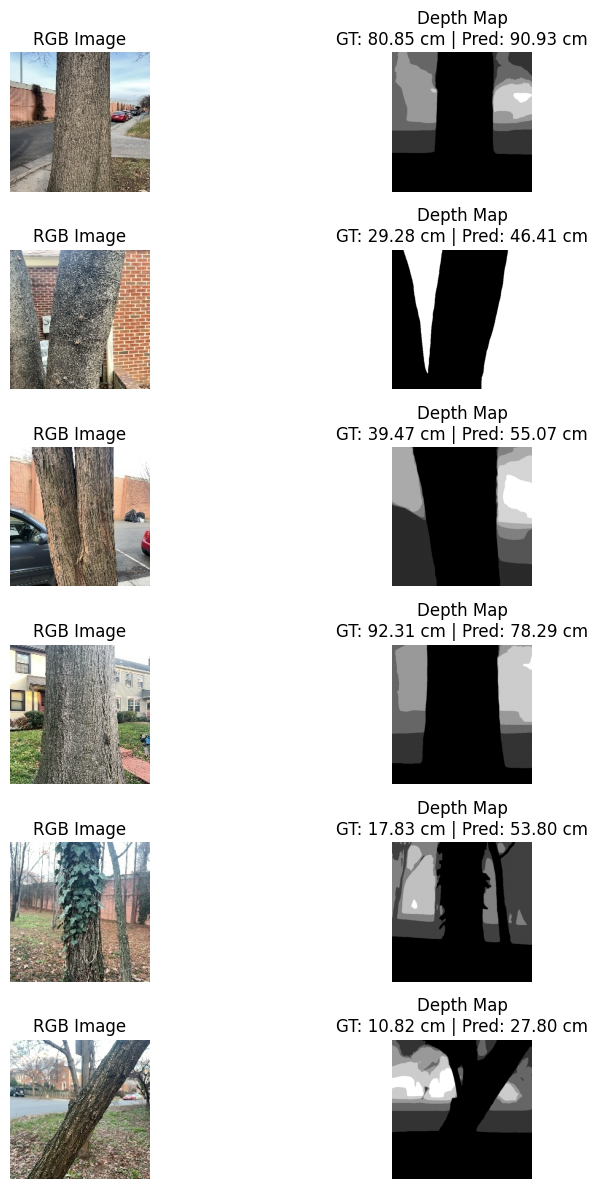

In [13]:
checkpoint = "../model/resnet50_depth_dbh_DA3_LARGE_20260210_0423_38_best.pt"
test_csv = "../dataset/DepthMapDBH2023/test/test/files_with_depth_maps_DA3_LARGE.csv"

visualize_random_test_samples(
    checkpoint_path=checkpoint,
    backbone="resnet50",
    test_csv=test_csv,
    base_path="../dataset/DepthMapDBH2023/",
    k=6,
)

In [ ]:
@torch.no_grad()
def visualize_random_test_samples_rgb(
    checkpoint_path: str,
    backbone: str,
    test_csv: str,
    base_path: str,
    k: int = 4,
    image_size: int = 224,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    base_path = Path(base_path)
    df = pd.read_csv(test_csv)
    # df = filter_dbh_dataframe(df, min_dbh=0)

    samples = df.sample(k)

    model = load_model(backbone, checkpoint_path, device)
    model.eval()

    # IMPORTANT: same transforms as eval (RGB, 3 channels)
    rgb_transform = get_eval_transforms(
        image_size=image_size,
        in_channels=3,
    )

    fig, axes = plt.subplots(k, 1, figsize=(6, 3 * k))

    if k == 1:
        axes = [axes]

    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = (
            base_path
            / row["image_path"].split("/")[0]
            / row["image_path"]
        )

        gt_dbh = row["DBH"]

        # --- RGB image
        img = Image.open(img_path).convert("RGB")

        # --- model input
        img_tensor = rgb_transform(img).unsqueeze(0).to(device)

        # predict
        pred_dbh = model(img_tensor).item()
        pred_dbh = np.expm1(pred_dbh)

        # --- plot
        axes[i].imshow(img)
        axes[i].set_title(
            f"GT: {gt_dbh:.2f} cm | Pred: {pred_dbh:.2f} cm"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


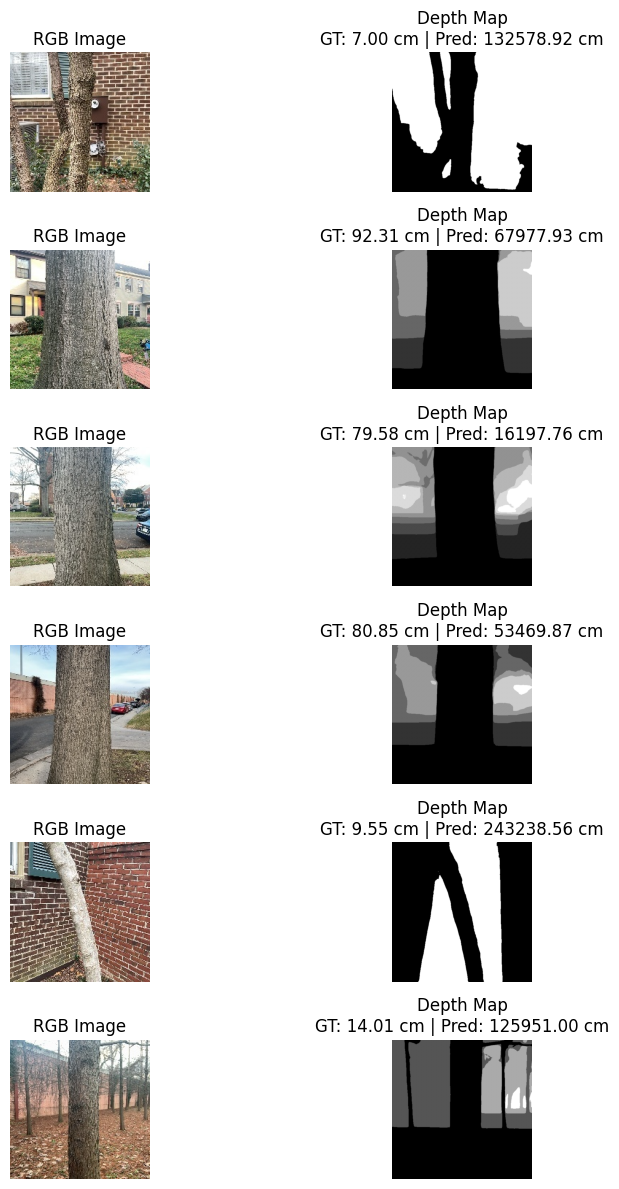

In [ ]:
checkpoint = "../.model/resnet50_depth_dbh_DA3_LARGE_20260210_0649_189_best.pt"

visualize_random_test_samples(
    checkpoint_path=checkpoint,
    backbone="resnet50",
    test_csv=test_csv,
    base_path="../dataset/DepthMapDBH2023/",
    
    k=6,
)